# <span style="color:white; font-size:50px">LIBRARIES</span>


In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split, learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE, SelectKBest, f_classif


# <span style="color:green; font-size:50px">DATA</span>


In [2]:
test=pd.read_csv('test.csv')
train=pd.read_csv('train.csv')

In [3]:
train.head()

,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
0,0,55.0,170.0,80.0,92.0,1.2,0.8,1.0,1.0,129.0,...,49.0,114.0,15.4,1.0,0.9,20.0,23.0,13.0,0.0,0.0
1,1,30.0,170.0,80.0,94.0,1.5,1.5,1.0,1.0,128.0,...,51.0,111.0,16.2,1.0,0.9,30.0,39.0,92.0,0.0,1.0
2,2,45.0,170.0,75.0,84.0,1.0,1.0,1.0,1.0,124.0,...,52.0,112.0,14.6,2.0,0.9,20.0,20.0,50.0,0.0,1.0
3,3,55.0,150.0,55.0,85.0,0.9,0.5,1.0,1.0,123.0,...,61.0,119.0,13.4,1.0,0.8,25.0,20.0,18.0,0.0,0.0
4,4,45.0,160.0,55.0,72.0,0.5,0.6,1.0,1.0,117.0,...,61.0,120.0,13.9,1.0,0.7,20.0,26.0,10.0,0.0,0.0


In [4]:
train.info

<bound method DataFrame.info of           id   age  height(cm)  weight(kg)  waist(cm)  eyesight(left)  \
0          0  55.0       170.0        80.0       92.0             1.2   
1          1  30.0       170.0        80.0       94.0             1.5   
2          2  45.0       170.0        75.0       84.0             1.0   
3          3  55.0       150.0        55.0       85.0             0.9   
4          4  45.0       160.0        55.0       72.0             0.5   
...      ...   ...         ...         ...        ...             ...   
14995  14995  40.0       170.0        70.0       81.0             1.0   
14996  14996  40.0       155.0        50.0       75.0             1.0   
14997  14997  45.0       160.0        55.0       81.0             1.2   
14998  14998  50.0       160.0        60.0       80.0             0.7   
14999  14999  55.0       175.0        75.0       85.0             0.9   

       eyesight(right)  hearing(left)  hearing(right)  systolic  ...   HDL  \
0            

In [5]:
train.dtypes

id                       int64
age                    float64
height(cm)             float64
weight(kg)             float64
waist(cm)              float64
eyesight(left)         float64
eyesight(right)        float64
hearing(left)          float64
hearing(right)         float64
systolic               float64
relaxation             float64
fasting blood sugar    float64
Cholesterol            float64
triglyceride           float64
HDL                    float64
LDL                    float64
hemoglobin             float64
Urine protein          float64
serum creatinine       float64
AST                    float64
ALT                    float64
Gtp                    float64
dental caries          float64
smoking                float64
dtype: object

# <span style="color:magenta; font-size:50px">FEATURE ENGINEERING</span>


In [6]:
def create_extra_features(df):
    best = np.where(df['hearing(left)'] < df['hearing(right)'], 
                    df['hearing(left)'],  df['hearing(right)'])
    worst = np.where(df['hearing(left)'] < df['hearing(right)'], 
                     df['hearing(right)'],  df['hearing(left)'])
    df['hearing(left)'] = best - 1
    df['hearing(right)'] = worst - 1
    
    df['eyesight(left)'] = np.where(df['eyesight(left)'] > 9, 0, df['eyesight(left)'])
    df['eyesight(right)'] = np.where(df['eyesight(right)'] > 9, 0, df['eyesight(right)'])
    best = np.where(df['eyesight(left)'] < df['eyesight(right)'], 
                    df['eyesight(left)'],  df['eyesight(right)'])
    worst = np.where(df['eyesight(left)'] < df['eyesight(right)'], 
                     df['eyesight(right)'],  df['eyesight(left)'])
    df['eyesight(left)'] = best
    df['eyesight(right)'] = worst
    ##
    df['Gtp'] = np.clip(df['Gtp'], 0, 300)
    df['HDL'] = np.clip(df['HDL'], 0, 110)
    df['LDL'] = np.clip(df['LDL'], 0, 200)
    df['ALT'] = np.clip(df['ALT'], 0, 150)
    df['AST'] = np.clip(df['AST'], 0, 100)
    df['serum creatinine'] = np.clip(df['serum creatinine'], 0, 3)  
    
    return df
train=create_extra_features(train)
test=create_extra_features(test)

In [7]:
def min_max_scaler(train, test, column):

    sc=MinMaxScaler()
    
    max_val=max(train[column].max(),test[column].max())
    min_val=min(train[column].min(),test[column].min())

    train[column]=(train[column]-min_val)/(max_val-min_val)
    test[column]=(test[column]-min_val)/(max_val-min_val)
    
    return train,test  

def OHE(train_df,test_df,cols,target):

    combined = pd.concat([train_df, test_df], axis=0)
    for col in cols:
        one_hot = pd.get_dummies(combined[col])
        counts = combined[col].value_counts()
        min_count_category = counts.idxmin()
        one_hot = one_hot.drop(min_count_category, axis=1)
        one_hot.columns=[str(f)+col+"_OHE" for f in one_hot.columns]
        combined = pd.concat([combined, one_hot], axis="columns")
        combined = combined.loc[:, ~combined.columns.duplicated()]
    
    train_ohe = combined[:len(train_df)]
    test_ohe = combined[len(train_df):]
    test_ohe.reset_index(inplace=True,drop=True)
    test_ohe.drop(columns=[target],inplace=True)
    return train_ohe, test_ohe


In [8]:
train['BMI'] = train['weight(kg)'] / (train['height(cm)'] / 100) ** 2

train['Pulse_Pressure'] = train['systolic'] - train['relaxation']

train['Cholesterol_Ratio'] = train['LDL'] / train['HDL']

train['Glucose_BMI'] = train['fasting blood sugar'] * train['BMI']

train['Age_Systolic'] = train['age'] * train['systolic']
train['Cholesterol_Weight'] = train['Cholesterol'] * train['weight(kg)']

train['BMI_Squared'] = train['BMI'] ** 2
train['Glucose_Squared'] = train['fasting blood sugar'] ** 2

scaler = StandardScaler()
numeric_features = ['BMI', 'Pulse_Pressure', 'Cholesterol_Ratio', 'Glucose_BMI', 'Age_Systolic', 'Cholesterol_Weight', 'BMI_Squared', 'Glucose_Squared']
train[numeric_features] = scaler.fit_transform(train[numeric_features])

train.head()


,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,dental caries,smoking,BMI,Pulse_Pressure,Cholesterol_Ratio,Glucose_BMI,Age_Systolic,Cholesterol_Weight,BMI_Squared,Glucose_Squared
0,0,55.0,170.0,80.0,92.0,0.8,1.2,0.0,0.0,129.0,...,0.0,0.0,1.444741,1.499075,0.458714,0.056000,1.393440,0.668635,1.462683,-0.934573
1,1,30.0,170.0,80.0,94.0,1.5,1.5,0.0,0.0,128.0,...,0.0,1.0,1.444741,-0.035643,0.194826,0.930300,-0.880841,1.075803,1.462683,-0.046295
2,2,45.0,170.0,75.0,84.0,1.0,1.0,0.0,0.0,124.0,...,0.0,1.0,0.835601,-0.035643,0.155039,0.720132,0.334903,0.825238,0.791692,0.177222
3,3,55.0,150.0,55.0,85.0,0.5,0.9,0.0,0.0,123.0,...,0.0,0.0,0.304973,-0.035643,-0.201993,0.183129,1.162867,-0.656619,0.242464,-0.046295
4,4,45.0,160.0,55.0,72.0,0.5,0.6,0.0,0.0,117.0,...,0.0,0.0,-0.737216,-0.454202,-0.173164,-0.082497,0.114812,-0.570487,-0.740637,0.565192


In [9]:
test['BMI'] = test['weight(kg)'] / (test['height(cm)'] / 100) ** 2

test['Pulse_Pressure'] = test['systolic'] - test['relaxation']

test['Cholesterol_Ratio'] = test['LDL'] / test['HDL']

test['Glucose_BMI'] = test['fasting blood sugar'] * test['BMI']

test['Age_Systolic'] = test['age'] * test['systolic']
test['Cholesterol_Weight'] = test['Cholesterol'] * test['weight(kg)']

test['BMI_Squared'] = test['BMI'] ** 2
test['Glucose_Squared'] = test['fasting blood sugar'] ** 2

scaler = StandardScaler()
numeric_features = ['BMI', 'Pulse_Pressure', 'Cholesterol_Ratio', 'Glucose_BMI', 'Age_Systolic', 'Cholesterol_Weight', 'BMI_Squared', 'Glucose_Squared']
test[numeric_features] = scaler.fit_transform(test[numeric_features])

test.head()

,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,Gtp,dental caries,BMI,Pulse_Pressure,Cholesterol_Ratio,Glucose_BMI,Age_Systolic,Cholesterol_Weight,BMI_Squared,Glucose_Squared
0,15000,40.0,175.0,70.0,84.0,1.5,1.5,0.0,0.0,120.0,...,25.0,0.0,-0.256678,2.297839,0.635895,0.089066,-0.212321,0.088628,-0.296980,0.306103
1,15001,45.0,155.0,55.0,72.4,0.5,0.6,0.0,0.0,102.0,...,13.0,0.0,-0.244387,-1.413896,-0.200222,-0.615944,-0.358676,-0.808513,-0.285718,-0.565387
2,15002,40.0,160.0,55.0,76.0,1.2,1.2,0.0,0.0,115.0,...,11.0,0.0,-0.729610,0.923122,-1.931856,-0.600667,-0.351706,-1.216127,-0.716992,-0.178218
3,15003,45.0,150.0,50.0,74.4,1.0,1.0,0.0,0.0,96.0,...,18.0,0.0,-0.475415,-2.101254,-1.925412,-1.555056,-0.546846,-1.307791,-0.494473,-1.420386
4,15004,35.0,185.0,80.0,90.0,0.8,1.0,0.0,0.0,113.0,...,20.0,0.0,-0.078366,-0.589066,-0.493284,-0.795645,-0.801224,0.911656,-0.131870,-0.868311


# <span style="color:yellow; font-size:50px">FEATURE SELECTION</span>


In [99]:
columns=[
       # 'age', 
       'height(cm)', 
       'weight(kg)', 
       'waist(cm)', 
       # 'eyesight(left)',
       # 'eyesight(right)', 
       # 'hearing(left)', 
       # 'hearing(right)', 
       'systolic',
       'relaxation', 
       'fasting blood sugar', 
       'Cholesterol', 
       'triglyceride',
       'HDL', 
       'LDL',
       'hemoglobin', 
       'Urine protein', 
       'serum creatinine', 
       'AST',
       'ALT', 
       'Gtp', 
       # 'dental caries',
       'BMI', 
       'Pulse_Pressure',
       'Cholesterol_Ratio', 
       'Glucose_BMI', 
       'Age_Systolic', 
       'Cholesterol_Weight', 
       'BMI_Squared',
       'Glucose_Squared'
       ]

    
X=train[columns]
y=train['smoking']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)


In [11]:


def feature_importance_rf(X, y):
    rf = RandomForestClassifier(random_state=42)
    rf.fit(X, y)
    feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': rf.feature_importances_})
    feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
    return feature_importances

def rfe_selection(X, y, num_features=10):
    rf = RandomForestClassifier(random_state=42)
    rfe = RFE(estimator=rf, n_features_to_select=num_features)
    rfe.fit(X, y)
    selected_features = X.columns[rfe.support_]
    return selected_features

def select_k_best(X, y, k=10):
    selector = SelectKBest(score_func=f_classif, k=k)
    selector.fit(X, y)
    selected_features = X.columns[selector.get_support()]
    return selected_features

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

importance_df = feature_importance_rf(X_scaled, y)
print("Top features based on RandomForest feature importance:\n", importance_df.head(10))

selected_rfe_features = rfe_selection(X_scaled, y, num_features=10)
print("\nTop features selected using RFE:\n", selected_rfe_features)

selected_k_best_features = select_k_best(X_scaled, y, k=10)
print("\nTop features selected using SelectKBest:\n", selected_k_best_features)


Top features based on RandomForest feature importance:
                Feature  Importance
10          hemoglobin    0.149647
1           height(cm)    0.105843
15                 Gtp    0.087827
7         triglyceride    0.070038
2           weight(kg)    0.043575
12    serum creatinine    0.041576
21        Age_Systolic    0.041252
22  Cholesterol_Weight    0.040714
19   Cholesterol_Ratio    0.037456
8                  HDL    0.037304

Top features selected using RFE:
 Index(['height(cm)', 'triglyceride', 'LDL', 'hemoglobin', 'ALT', 'Gtp',
       'Cholesterol_Ratio', 'Glucose_BMI', 'Age_Systolic',
       'Cholesterol_Weight'],
      dtype='object')

Top features selected using SelectKBest:
 Index(['height(cm)', 'weight(kg)', 'triglyceride', 'HDL', 'hemoglobin',
       'serum creatinine', 'ALT', 'Gtp', 'Cholesterol_Ratio',
       'Cholesterol_Weight'],
      dtype='object')


# <span style="color:BLUE; font-size:50px">ML</span>


In [100]:
rf_model = RandomForestClassifier(
    n_estimators=100,      
    max_depth=7,        
    criterion='log_loss',
    random_state=42
)

rf_model.fit(X, y)

y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

roc_auc = roc_auc_score(y_test, y_pred_proba)
accuracy = accuracy_score(y_test, y_pred)

print(f"ROC-AUC: {roc_auc:.4f}")
print(f"Accuracy: {accuracy:.4f}")


ROC-AUC: 0.9102
Accuracy: 0.8249


In [101]:

skf = StratifiedKFold(n_splits=10)
train_scores = []
val_scores = []

for train_index, val_index in skf.split(X, y):
    X_tr, X_val = X.iloc[train_index], X.iloc[val_index]
    y_tr, y_val = y.iloc[train_index], y.iloc[val_index]

    rf_model.fit(X_tr, y_tr)

    train_proba = rf_model.predict_proba(X_tr)[:, 1]
    val_proba = rf_model.predict_proba(X_val)[:, 1]

    train_auc = roc_auc_score(y_tr, train_proba)
    val_auc = roc_auc_score(y_val, val_proba)

    train_scores.append(train_auc)
    val_scores.append(val_auc)

train_scores = np.array(train_scores)
val_scores = np.array(val_scores)

train_mean = train_scores.mean()
train_std = train_scores.std()
val_mean = val_scores.mean()
val_std = val_scores.std()
score_diff = train_mean - val_mean


In [97]:

print(f"Train ROC-AUC Scores: {train_scores}")
print(f"Validation ROC-AUC Scores: {val_scores}")
print(f"Train Mean: {train_mean:.4f} +- {train_std:.4f}")
print(f"Validation Mean: {val_mean:.4f} +- {val_std:.4f}")
print(f"Difference (Train - Validation): {score_diff:.4f}")



Train ROC-AUC Scores: [0.8995029  0.89785741 0.89951721 0.89772011 0.89796457 0.89796024
 0.89959864 0.8988907  0.89937604 0.898326  ]
Validation ROC-AUC Scores: [0.86675731 0.87786309 0.86704946 0.86937018 0.87367292 0.88408919
 0.86140962 0.86443013 0.86413056 0.86675609]
Train Mean: 0.8987 +- 0.0007
Validation Mean: 0.8696 +- 0.0066
Difference (Train - Validation): 0.0291


In [103]:
train_sizes, train_scores, val_scores = learning_curve(
    rf_model, X_train, y_train, cv=skf, scoring='roc_auc', train_sizes=np.linspace(0.1, 1.0, 10)
)

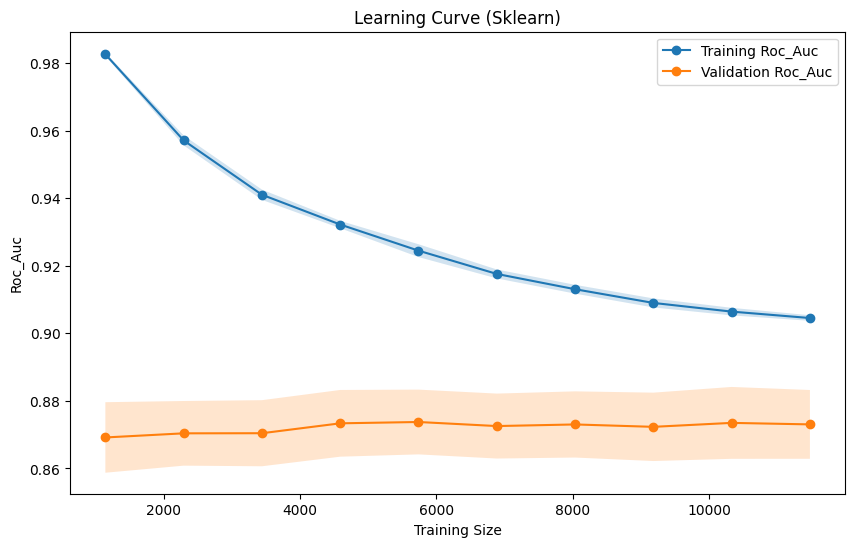

In [104]:

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', label='Training Roc_Auc')
plt.plot(train_sizes, val_mean, 'o-', label='Validation Roc_Auc')

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2)
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2)

plt.xlabel('Training Size')
plt.ylabel('Roc_Auc')
plt.title('Learning Curve (Sklearn)')
plt.legend(loc='best')
plt.show()


# SUBMISSION

In [105]:
rf_model.fit(X, y)

y_pred_proba = rf_model.predict_proba(X)[:, 1]

roc_auc = roc_auc_score(y, y_pred_proba)
print(f'ROC AUC: {roc_auc:.5f}')

ROC AUC: 0.90036


In [106]:
y_pred_final = rf_model.predict_proba(test[columns])[:, 1]

sub = pd.read_csv('sample_submission.csv')
sub['smoking'] = y_pred_final
sub.to_csv('sample_submission.csv', index=False)
sub.head()

,id,smoking
0,15000,0.666049
1,15001,0.021369
2,15002,0.022625
3,15003,0.043623
4,15004,0.521544
